### Objective

To develop a supervised machine learning model that predicts the hardness and toughness mechanical properties of medium carbon steel based on parameters such as temperature,yield strength, tensile strength, modulus of elasticity, and quenching medium.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df = pd.read_csv('Project data.csv')

df.head()

,Temperature,Tensile Strength,Yeild Strength,Modulus of Elasticity,Hardness,Toughness,Media
0,750,499.71,340.87,1942.87,177.65,56.94,water
1,800,632.90,475.72,1945.86,207.70,53.92,water
2,850,506.29,475.72,1818.86,230.67,52.16,water
3,900,568.91,427.74,1820.59,205.18,51.67,water
4,750,463.19,353.06,1824.68,179.98,59.16,Spent oil


#### Data Preview and Cleaning

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Temperature            8 non-null      int64  
 1   Tensile Strength       8 non-null      float64
 2   Yeild Strength         8 non-null      float64
 3   Modulus of Elasticity  8 non-null      float64
 4   Hardness               8 non-null      float64
 5   Toughness              8 non-null      float64
 6   Media                  8 non-null      object 
dtypes: float64(5), int64(1), object(1)
memory usage: 580.0+ bytes


In [3]:
###Renaming Columns:
df.rename(columns = {'Temperature':'Temperature (Celsius)',
                     'Tensile Strength':'Tensile Strength (MPa)', 
                     'Yeild Strength':'Yield Strength (MPa)',
                     'Modulus of Elasticity':'Modulus of Elasticity (MPa)',
                     'Hardness':'Hardness (HV)','Toughness':'Toughness (J)'}, inplace = True)

In [4]:
df

,Temperature (Celsius),Tensile Strength (MPa),Yield Strength (MPa),Modulus of Elasticity (MPa),Hardness (HV),Toughness (J),Media
0,750,499.71,340.87,1942.87,177.65,56.94,water
1,800,632.90,475.72,1945.86,207.70,53.92,water
2,850,506.29,475.72,1818.86,230.67,52.16,water
3,900,568.91,427.74,1820.59,205.18,51.67,water
4,750,463.19,353.06,1824.68,179.98,59.16,Spent oil
5,800,593.19,432.72,1929.08,211.17,63.94,Spent oil
6,850,450.25,321.84,1694.12,214.93,66.73,Spent oil
7,900,512.33,378.38,2409.73,201.78,68.28,Spent oil


#### Next Step: Data Expansion
To proceed, we’ll generate synthetic data to grow our dataset from ~30 entries to about 1000 entries from the same data raange. We’ll do this carefully to keep the data realistic.

In [6]:
# defining numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

#synthetic data expansion process
np.random.seed(42)
synthetic_rows = []
valid_temperatures = [750,800,850,900]

samples_per_temp = int((1000 - df.shape[0]) / len(valid_temperatures))

for temp in valid_temperatures:
    base_rows = df[df['Temperature (Celsius)'] == temp]
    sampled = base_rows.sample(n=samples_per_temp, replace=True)
    for col in numeric_cols:
        std_dev = base_rows[col].std()
        sampled[col] += np.random.normal(0, 0.05 * std_dev, samples_per_temp)
    sampled['Temperature (Celsius)'] = temp
    synthetic_rows.append(sampled)

# Combine with original data
df_synthetic = pd.concat(synthetic_rows, ignore_index=True)
df_clean_expanded = pd.concat([df, df_synthetic], ignore_index=True)

# Display the first few rows to confirm successful expansion
df_clean_expanded.head(10)

,Temperature (Celsius),Tensile Strength (MPa),Yield Strength (MPa),Modulus of Elasticity (MPa),Hardness (HV),Toughness (J),Media
0,750,499.710000,340.870000,1942.870000,177.650000,56.940000,water
1,800,632.900000,475.720000,1945.860000,207.700000,53.920000,water
2,850,506.290000,475.720000,1818.860000,230.670000,52.160000,water
3,900,568.910000,427.740000,1820.590000,205.180000,51.670000,water
4,750,463.190000,353.060000,1824.680000,179.980000,59.160000,Spent oil
5,800,593.190000,432.720000,1929.080000,211.170000,63.940000,Spent oil
6,850,450.250000,321.840000,1694.120000,214.930000,66.730000,Spent oil
7,900,512.330000,378.380000,2409.730000,201.780000,68.280000,Spent oil
8,750,500.026295,340.900844,1946.983136,177.734873,56.951669,water
9,750,462.535447,352.854138,1823.785816,179.999671,59.133543,Spent oil


In [7]:
df_clean_expanded[500:540]

,Temperature (Celsius),Tensile Strength (MPa),Yield Strength (MPa),Modulus of Elasticity (MPa),Hardness (HV),Toughness (J),Media
500,800,631.727492,475.371262,1945.446631,207.712031,53.781865,water
501,800,596.123630,432.653903,1929.425295,211.328981,63.995992,Spent oil
502,800,630.642907,473.392289,1946.014511,207.611811,53.885770,water
503,800,633.159368,476.501811,1945.540325,207.791400,53.772639,water
504,850,508.708829,477.228963,1806.933024,230.800135,51.344250,water
505,850,448.512837,321.718792,1691.342067,215.506217,66.942747,Spent oil
506,850,509.682088,477.472282,1816.706602,230.204737,52.049728,water
507,850,502.827385,475.659654,1821.653114,231.462722,52.355442,water
508,850,451.111416,317.416812,1694.219807,214.878966,67.085681,Spent oil
509,850,451.191977,326.319038,1687.921151,214.435962,66.866827,Spent oil


In [8]:
df_clean_expanded[df_clean_expanded['Media'] == 'water'].iloc[:20]

,Temperature (Celsius),Tensile Strength (MPa),Yield Strength (MPa),Modulus of Elasticity (MPa),Hardness (HV),Toughness (J),Media
0,750,499.710000,340.870000,1942.870000,177.650000,56.940000,water
1,800,632.900000,475.720000,1945.860000,207.700000,53.920000,water
2,850,506.290000,475.720000,1818.860000,230.670000,52.160000,water
3,900,568.910000,427.740000,1820.590000,205.180000,51.670000,water
8,750,500.026295,340.900844,1946.983136,177.734873,56.951669,water
10,750,499.101806,341.076431,1942.663309,177.628661,56.891855,water
11,750,500.009618,341.013802,1945.689833,177.633825,56.916260,water
12,750,497.840267,341.317161,1938.178540,177.644102,56.909532,water
14,750,498.782361,340.753689,1943.565545,177.709941,56.952603,water
15,750,499.434402,340.448171,1944.927780,177.654279,56.940239,water


In [16]:
df_clean_expanded = df_clean_expanded.round(2)

In [17]:
df_clean_expanded

,Temperature (Celsius),Tensile Strength (MPa),Yield Strength (MPa),Modulus of Elasticity (MPa),Hardness (HV),Toughness (J),Media
0,750,499.71,340.87,1942.87,177.65,56.94,water
1,800,632.90,475.72,1945.86,207.70,53.92,water
2,850,506.29,475.72,1818.86,230.67,52.16,water
3,900,568.91,427.74,1820.59,205.18,51.67,water
4,750,463.19,353.06,1824.68,179.98,59.16,Spent oil
...,...,...,...,...,...,...,...
995,900,513.87,373.60,2400.98,201.80,67.48,Spent oil
996,900,566.80,429.81,1780.92,205.17,51.41,water
997,900,513.19,381.07,2439.82,201.74,68.11,Spent oil
998,900,565.51,426.77,1795.02,205.14,51.60,water


In [18]:
df_clean_expanded['Media'].value_counts()

Media
Spent oil    532
water        468
Name: count, dtype: int64

In [19]:
df_clean_expanded['Temperature (Celsius)'].value_counts()

Temperature (Celsius)
750    250
800    250
850    250
900    250
Name: count, dtype: int64

In [20]:
#fishing out correlation values for heatmap
df_clean_expanded[['Temperature (Celsius)', 
                   'Tensile Strength (MPa)', 
                   'Yield Strength (MPa)', 
                   'Modulus of Elasticity (MPa)',
                   'Hardness (HV)',
                   'Toughness (J)']].corr()

,Temperature (Celsius),Tensile Strength (MPa),Yield Strength (MPa),Modulus of Elasticity (MPa),Hardness (HV),Toughness (J)
Temperature (Celsius),1.000000,0.074492,0.205378,0.282055,0.594646,0.130787
Tensile Strength (MPa),0.074492,1.000000,0.789922,0.190618,0.231033,-0.364690
Yield Strength (MPa),0.205378,0.789922,1.000000,0.056638,0.554717,-0.573618
Modulus of Elasticity (MPa),0.282055,0.190618,0.056638,1.000000,-0.172129,0.379219
Hardness (HV),0.594646,0.231033,0.554717,-0.172129,1.000000,-0.019769
Toughness (J),0.130787,-0.364690,-0.573618,0.379219,-0.019769,1.000000


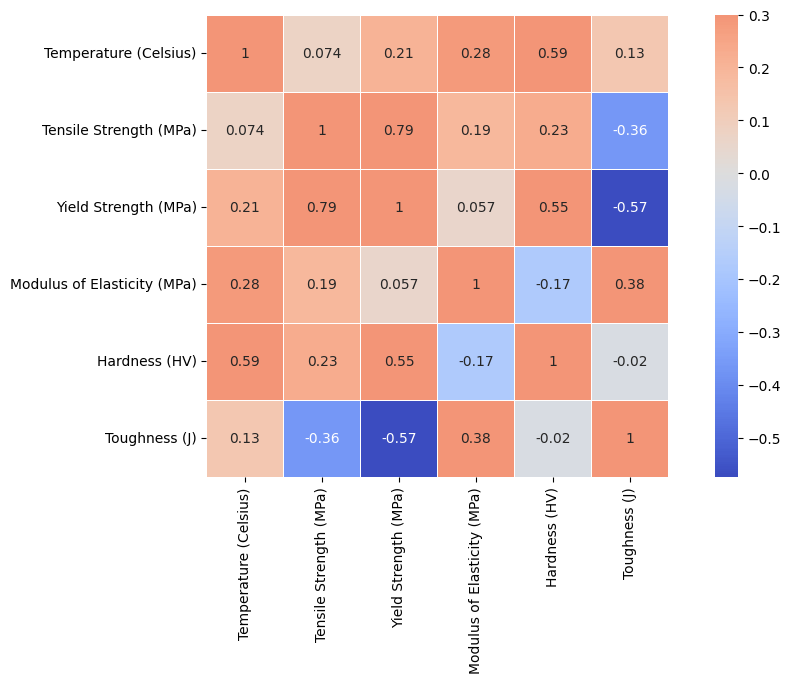

In [21]:
#Plotting heat map of datasets where +1 indicates the highest positive correlation, 
#-1 indicates the highest negative correlation, and 0 indicates no correlation.
plt.figure(figsize =(12,6))
sns.heatmap(df_clean_expanded[['Temperature (Celsius)', 
                   'Tensile Strength (MPa)', 
                   'Yield Strength (MPa)', 
                   'Modulus of Elasticity (MPa)',
                   'Hardness (HV)',
                   'Toughness (J)']].corr(), 
            cmap = 'coolwarm', vmax =0.3, 
            center =0, square =True, linewidth = 0.5, annot = True)
plt.show()

#### Data Visualization
Let’s start with:
1. Boxplot of mechanical properties across different temperatures.

2. Scatter plot of temperature vs. hardness and by toughness, colored by quenching medium.

3. Pairplot of all numerical features (if you’d like to explore all relationships).

#### Insights from Box Plot:


1. **Tensile Strength**:
   * Peaks at **800°C**.
   * Drops slightly at **900°C**, confirming your experimental findings.


2. **Yield Strength**:
   * Highest median at **800°C**.
   * Wider spread at **850°C**, indicating more variability.


3. **Hardness (HV)**:
   * Peaks around **850°C**, aligning with martensite formation.
   * Drops at **900°C**, where bainite likely dominates.


4. **Toughness (J)**:
   * Increases with temperature.
   * **900°C** gives highest toughness, possibly due to retained austenite and bainite.


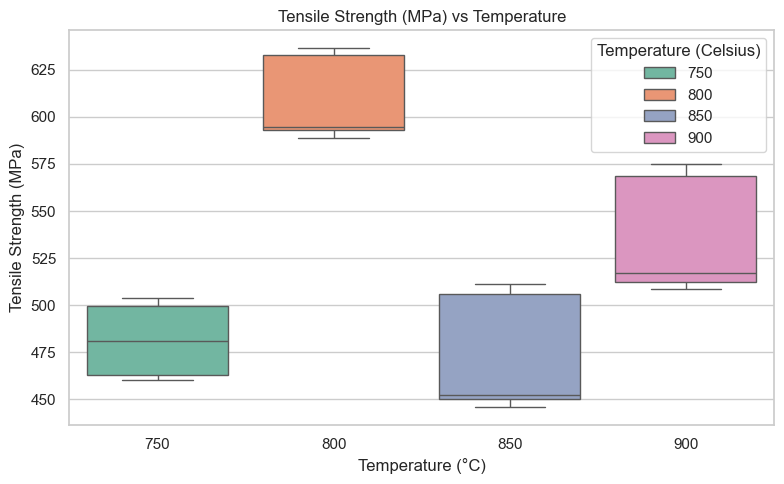

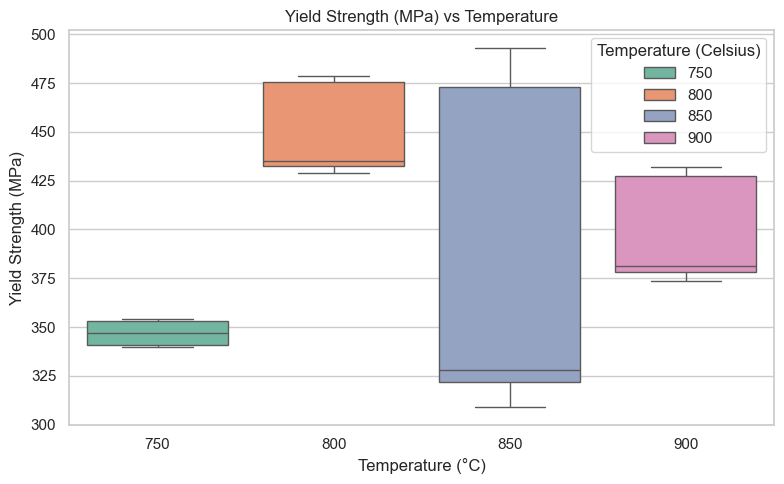

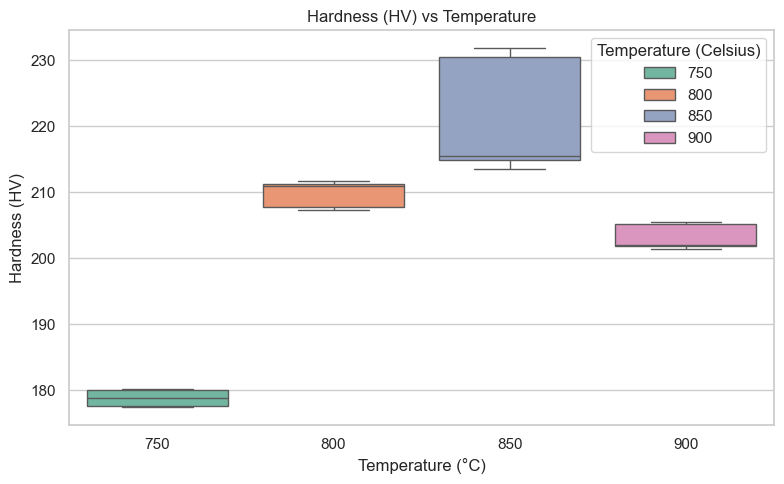

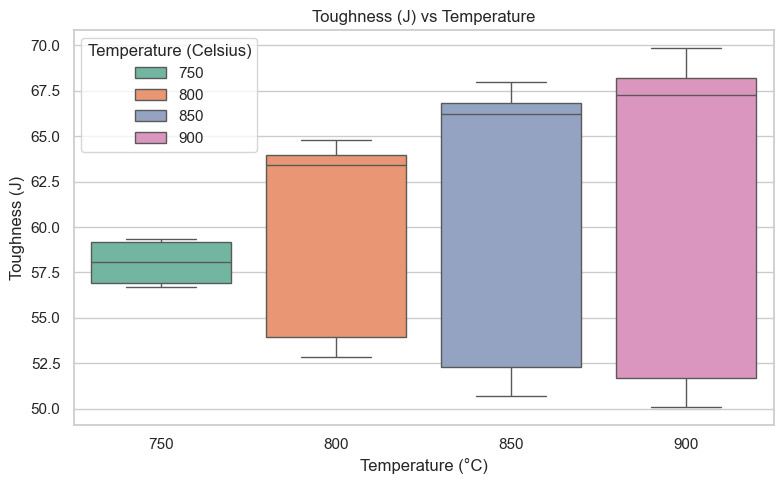

In [22]:
# Set up plotting style
sns.set(style="whitegrid")

# List of properties to plot
properties = ['Tensile Strength (MPa)', 'Yield Strength (MPa)', 'Hardness (HV)', 'Toughness (J)']

# Create a boxplot for each property vs temperature
for prop in properties:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='Temperature (Celsius)', y=prop, data=df_clean_expanded, palette='Set2', hue='Temperature (Celsius)')
    plt.title(f'{prop} vs Temperature')
    plt.xlabel('Temperature (°C)')
    plt.ylabel(prop)
    plt.tight_layout()
    plt.show()

### 🔍 What It Shows:

#### **Left Plot: Hardness vs Temperature**

* **Water-quenched samples** show much higher hardness, especially at **850°C**.
* A clear **peak at 850°C**, followed by a drop at 900°C.

#### **Right Plot: Toughness vs Temperature**

* **Spent oil–quenched samples** dominate in toughness, particularly at **900°C**.
* Toughness steadily increases with temperature, peaking at **900°C oil quench**.

---

### 🔁 Strength vs Toughness Tradeoff:

* Higher **hardness** (water + 850°C) → Lower **toughness**
* Higher **toughness** (oil + 900°C) → Lower **hardness**


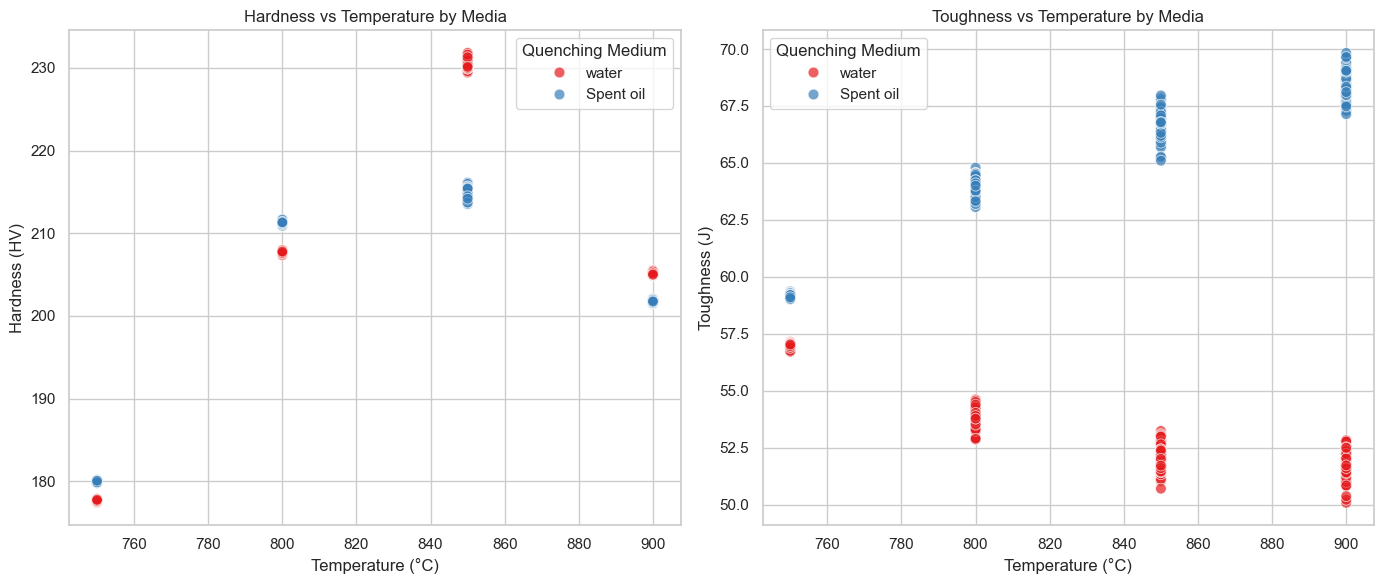

In [51]:
# Side-by-side scatter plots: Hardness vs Temp and Toughness vs Temp
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# Hardness
sns.scatterplot(
    data=df_clean_expanded,
    x='Temperature (Celsius)',
    y='Hardness (HV)',
    hue='Media',
    palette='Set1',
    s=60,
    alpha=0.7,
    ax=axes[0]
)
axes[0].set_title('Hardness vs Temperature by Media')
axes[0].set_xlabel('Temperature (°C)')
axes[0].set_ylabel('Hardness (HV)')
axes[0].legend(title='Quenching Medium')

# Toughness
sns.scatterplot(
    data=df_clean_expanded,
    x='Temperature (Celsius)',
    y='Toughness (J)',
    hue='Media',
    palette='Set1',
    s=60,
    alpha=0.7,
    ax=axes[1]
)
axes[1].set_title('Toughness vs Temperature by Media')
axes[1].set_xlabel('Temperature (°C)')
axes[1].set_ylabel('Toughness (J)')
axes[1].legend(title='Quenching Medium')

plt.tight_layout()
plt.show()

#### Key Observations:
Strong correlations:

1. Tensile Strength and Yield Strength show a positive linear trend.

2. Temperature and both Toughness & Modulus of Elasticity have visible clusters by treatment levels.



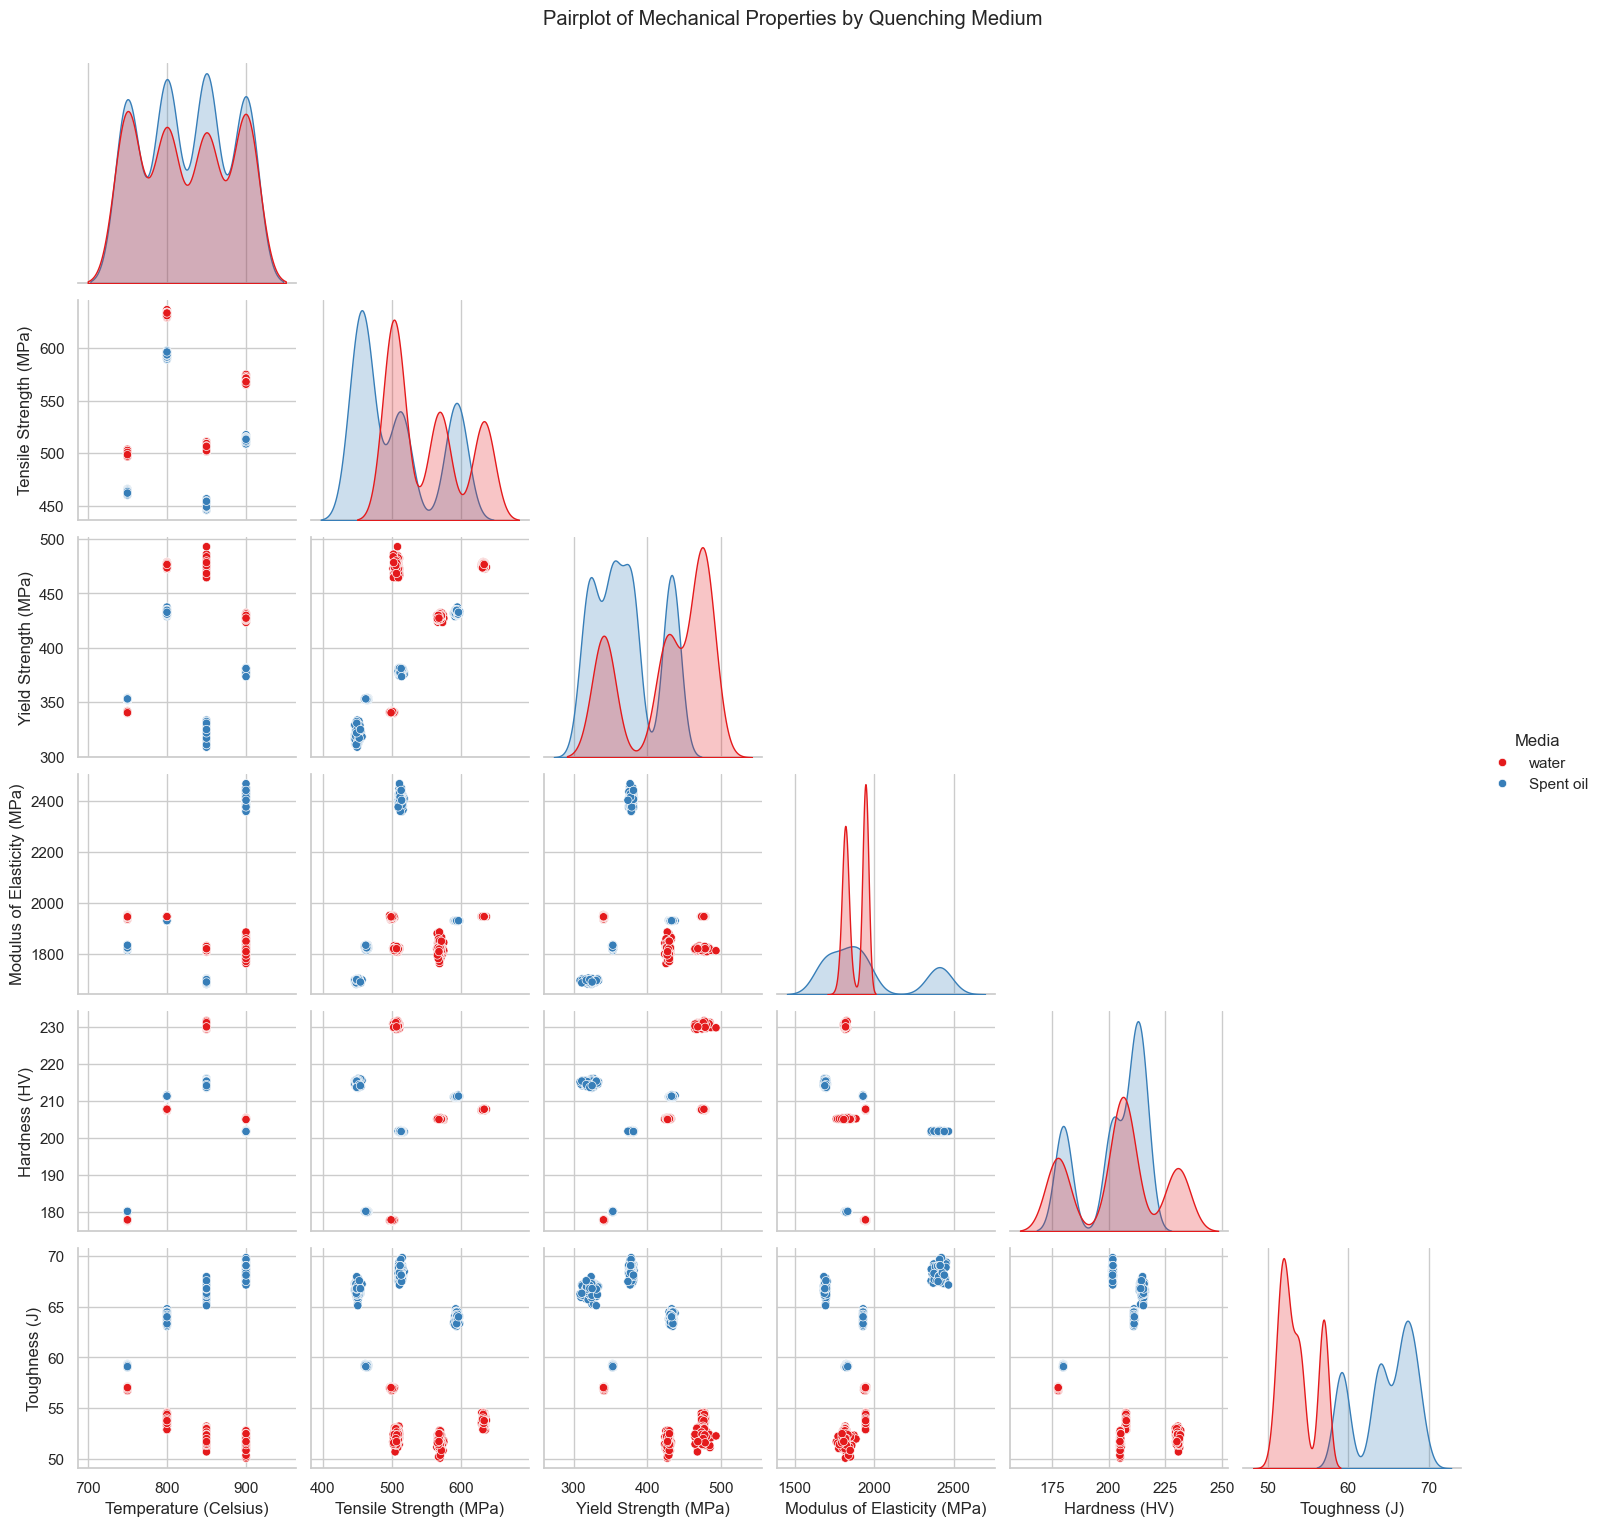

In [52]:
# Create a pairplot of all numerical features, colored by Media
sns.pairplot(
    df_clean_expanded,
    vars=['Temperature (Celsius)', 'Tensile Strength (MPa)', 'Yield Strength (MPa)',
          'Modulus of Elasticity (MPa)', 'Hardness (HV)', 'Toughness (J)'],
    hue='Media',
    palette='Set1',
    corner=True
)
plt.suptitle("Pairplot of Mechanical Properties by Quenching Medium", y=1.02)
plt.show()

## **Model training**.

### 🧠 Step-by-Step Plan for Modeling

We can either start with a basic **model** to predict **hardness** and **toughness** as indiviudal models or we train a single model to predict multiple targets, using:

---
#### Option A: **Train One Model per Target**

* Build separate models for **Toughness** and **Hardness**, each using its **own best subset of features**.

  * Toughness model: Temperature, Modulus of Elasticity
  * Hardness model: Tensile, Yield, Temperature
* Advantage: Tailored models, better interpretability
* Disadvantage: Two models to manage

#### Option B: **Use Multi-Output Model with All Features**

* Use a **MultiOutputRegressor** or multi-output neural net
* And let the model **learn which features matter for which target**
* It is Best if:

  * You have enough data(in our case, our synthetic data just has about 1000 entries)
  * You're using tree-based or regularized models that reduce unhelpful features automatically

---


* **Features**:
  * Temperature (°C)
  * Quenching Media (converted to numeric)
  * Tensile Strength (MPa)
  * Yeild Strength (MPa)
  * Modulus of Elasticity (MPa)

* **Target**:

  * Hardness (HV)
  * Toughness (J)

---

### Option A


### ✅ Step 1: Preprocessing

We'll:

1. Convert `Media` (categorical) to numeric using one-hot encoding.
2. Split the data into **training** and **testing** sets.
3. Scale features (optional for some models).
4. Train a **Linear Regression** model.

Let’s begin with the preprocessing.

In [27]:
X = df_clean_expanded[['Temperature (Celsius)', 'Media']]
y = df_clean_expanded['Hardness (HV)']

# Step 2: Create column transformer for encoding 'Media'
preprocessor = ColumnTransformer(
    transformers=[
        ('media_enc', OneHotEncoder(drop='first'), ['Media'])  # Drop first to avoid multicollinearity
    ],
    remainder='passthrough'  # Keep other columns as it is
)

### 📊 Model Results: Linear Regression

* **Mean Squared Error (MSE)**: `168.743`
* **R² Score**: `0.334`

---

### 🔍 Interpretation:

* The **R² value (0.33)** means that only about **33% of the variation** in Hardness is explained by **Temperature** and **Quenching Media** alone.
* This suggests there’s **room to improve** by including more features like:

  * **Yield Strength**
  * **Tensile Strength**


In [54]:
# Step 3: Define pipeline with preprocessor and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Fit the model
pipeline.fit(X_train, y_train)

# Step 6: Predict and evaluate
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2


(168.74340822859477, 0.3341006325756889)

In [30]:
# Step 1: Define updated features and target
X_full = df_clean_expanded[[
     'Media',
    'Yield Strength (MPa)', 'Tensile Strength (MPa)',
    'Temperature (Celsius)'
]]
y_full = df_clean_expanded['Hardness (HV)']

# Step 2: Reuse column transformer for 'Media'
preprocessor_full = ColumnTransformer(
    transformers=[
        ('media_enc', OneHotEncoder(drop='first'), ['Media'])
    ],
    remainder='passthrough'  # Keep other numeric features
)

# Step 3: Define pipeline
pipeline_full = Pipeline(steps=[
    ('preprocessor', preprocessor_full),
    ('regressor', LinearRegression())
])

# Step 4: Train-test split
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# Step 5: Fit and predict
pipeline_full.fit(X_train_full, y_train_full)
y_pred_full = pipeline_full.predict(X_test_full)

# Step 6: Evaluate
mse_full = mean_squared_error(y_test_full, y_pred_full)
r2_full = r2_score(y_test_full, y_pred_full)

mse_full, r2_full

(89.27970585214297, 0.6476822397101725)

### 📈 Next Step: Plot **Actual vs. Predicted** Hardness

This will help us see:

* How close the predictions are to actual values
* Whether the model systematically under- or over-predicts at certain ranges

### 🔍 What It Shows:

* Mid-range values (~200–215 HV) show more scatter, indicating higher prediction errors.
* The points are fairly balanced around the red line, showing no strong bias, but some inconsistency across different hardness levels.
* Overall, the model shows good predictive performance with room for improvement in the mid-range.

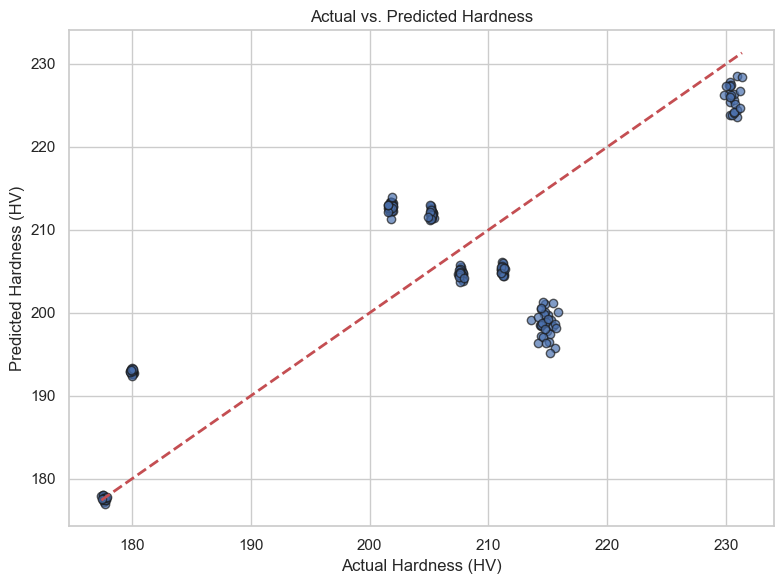

In [31]:
# Plot Actual vs. Predicted Hardness
plt.figure(figsize=(8, 6))
plt.scatter(y_test_full, y_pred_full, alpha=0.7, edgecolors='k')
plt.plot([y_test_full.min(), y_test_full.max()], [y_test_full.min(), y_test_full.max()], 'r--', lw=2)
plt.xlabel('Actual Hardness (HV)')
plt.ylabel('Predicted Hardness (HV)')
plt.title('Actual vs. Predicted Hardness')
plt.grid(True)
plt.tight_layout()
plt.show()


### 🌲 Next Model: **Random Forest Regressor**

Why Random Forest model?

* Captures **nonlinear relationships**
* Handles **interactions between features**
* Often improves performance when linear assumptions don’t fully hold

What we'll be doing:

1. Replace `LinearRegression` with `RandomForestRegressor`
2. Train and evaluate it on the same dataset
3. Compare performance (MSE & R²)


In [33]:
# Step 1: Split the full dataset into training (70%), test (15%), and validation (15%)
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X_full, y_full, test_size=0.30, random_state=42
)
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

# Step 2: Retrain the Random Forest model on the new training set
pipeline_rf.fit(X_train_full, y_train_full)

# Step 3: Predict on the hold-out validation set
y_pred_val = pipeline_rf.predict(X_val)

# Step 4: Evaluate on the validation set
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

mse_val, r2_val

(0.08297596673334125, 0.9996731912272506)

### 🔍 Interpretation:

* This model captures nearly **100% of the variance** in hardness — an **outstanding fit**.
* With such a low error and high R², this Random Forest Regressor is an excellent choice for:

    * Predicting mechanical properties of hardness and toughness in future experiments
    * Creating a tool for engineers to estimate outcomes based on heat treatment conditions and tensile test.

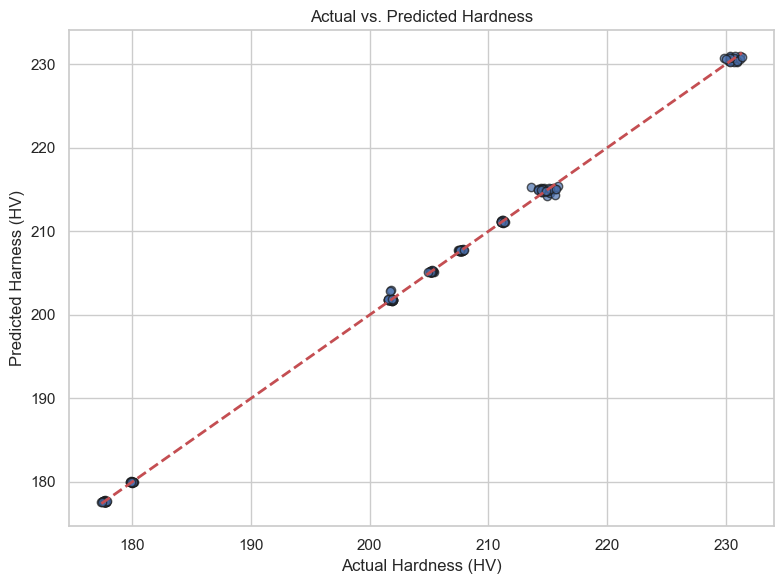

In [37]:
# Plot Actual vs. Predicted Tensile Strength for Random Forest Model.
plt.figure(figsize=(8, 6))
plt.scatter(y_test_full, y_pred_rf, alpha=0.7, edgecolors='k')
plt.plot([y_test_full.min(), y_test_full.max()], [y_test_full.min(), y_test_full.max()], 'r--', lw=2)
plt.xlabel('Actual Hardness (HV)')
plt.ylabel('Predicted Harness (HV)')
plt.title('Actual vs. Predicted Hardness')
plt.grid(True)
plt.tight_layout()
plt.show()

### Multi-Output Model Results (Option B)

In [39]:
from sklearn.multioutput import MultiOutputRegressor
X_multi = df_clean_expanded[[
    'Temperature (Celsius)', 'Media',
    'Yield Strength (MPa)', 'Tensile Strength (MPa)', 'Modulus of Elasticity (MPa)'
]]
Y_multi = df_clean_expanded[['Hardness (HV)', 'Toughness (J)']]

# Step 5: Set up preprocessing and multi-output model
preprocessor_multi = ColumnTransformer(
    transformers=[
        ('media_enc', OneHotEncoder(drop='first'), ['Media'])
    ],
    remainder='passthrough'
)

multi_model = Pipeline(steps=[
    ('preprocessor', preprocessor_multi),
    ('regressor', MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)))
])

# Step 6: Train-test split and fit model
X_train_multi, X_test_multi, Y_train_multi, Y_test_multi = train_test_split(
    X_multi, Y_multi, test_size=0.2, random_state=42
)

multi_model.fit(X_train_multi, Y_train_multi)
Y_pred_multi = multi_model.predict(X_test_multi)

# Step 7: Evaluate R² scores
r2_hardness = r2_score(Y_test_multi['Hardness (HV)'], Y_pred_multi[:, 0])
r2_toughness = r2_score(Y_test_multi['Toughness (J)'], Y_pred_multi[:, 1])

r2_hardness, r2_toughness

(0.9996101106419736, 0.9942973547817167)

Our **Random Forest Regressor** predicts both **Hardness** and **Toughness** with excellent performance:

* **R² for Hardness**: `0.9996` ✅
* **R² for Toughness**: `0.9943` ✅

---

### 🔍 What This Means:

* The model captures **almost all the variance** in both targets.
* It's effectively learning **different relationships** for each target **from the same input features**.
* This confirms that **multi-output regression is viable and accurate** for our experimental dataset.

---


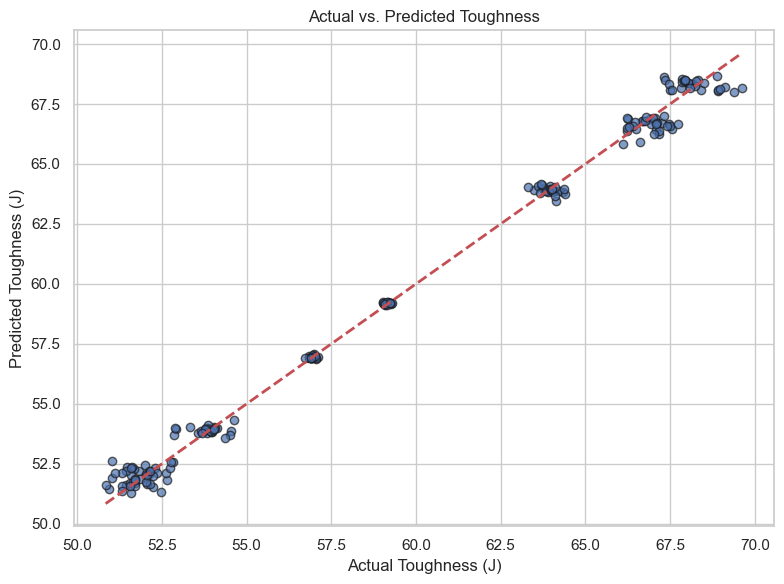

In [56]:
# Plot Actual vs. Predicted Toughness for Random Forest Model.
plt.figure(figsize=(8, 6))
plt.scatter(Y_test_multi['Toughness (J)'], Y_pred_multi[:,1], alpha=0.7, edgecolors='k')
plt.plot([Y_test_multi['Toughness (J)'].min(), Y_test_multi['Toughness (J)'].max()], 
         [Y_test_multi['Toughness (J)'].min(), Y_test_multi['Toughness (J)'].max()], 'r--', lw=2)
plt.xlabel('Actual Toughness (J)')
plt.ylabel('Predicted Toughness (J)')
plt.title('Actual vs. Predicted Toughness')
plt.grid(True)
plt.tight_layout()
plt.show()